<a href="https://colab.research.google.com/github/janzaw04/myTestRep/blob/main/%C4%86wiczenia_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np





import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model
from IPython.display import Image 

from keras.callbacks import EarlyStopping

batch_size = 128
num_classes = 10
epochs = 200

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

! pip install optuna


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)

N_TRAIN_EXAMPLES=500 #3000
N_TEST_EXAMPLES=10000

x_train=x_train[:N_TRAIN_EXAMPLES]
x_test=x_test[:N_TEST_EXAMPLES]
y_train=y_train[:N_TRAIN_EXAMPLES]
y_test=y_test[:N_TEST_EXAMPLES]

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



500 train samples
10000 test samples


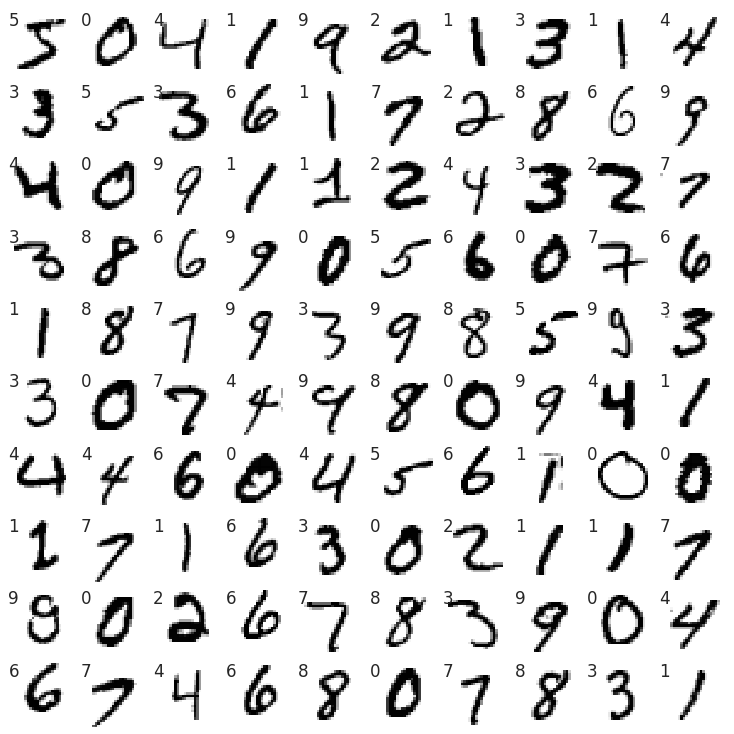

In [ ]:
#visualize the digits

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train0[i]))

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=False,
    vertical_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15
    )
datagen.fit(x_train)

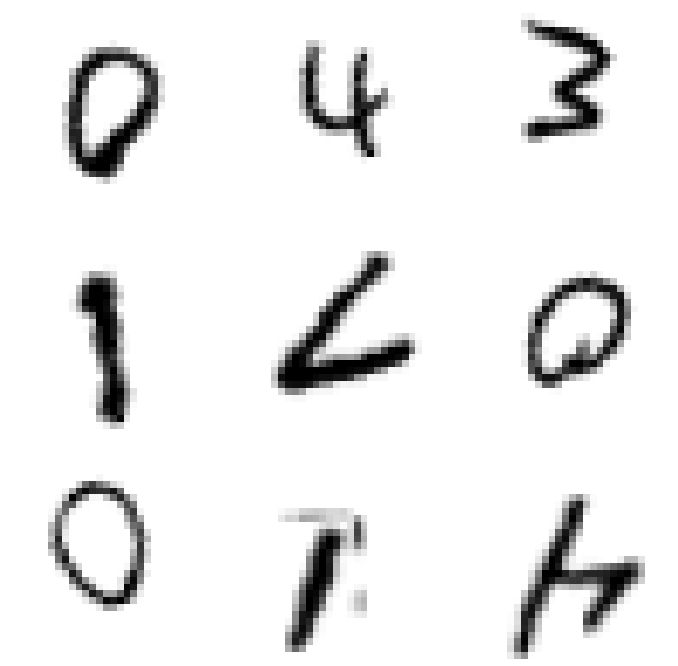

In [ ]:
# see example augmentation images

fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape(img_rows,img_cols),cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
    plt.show()
    break

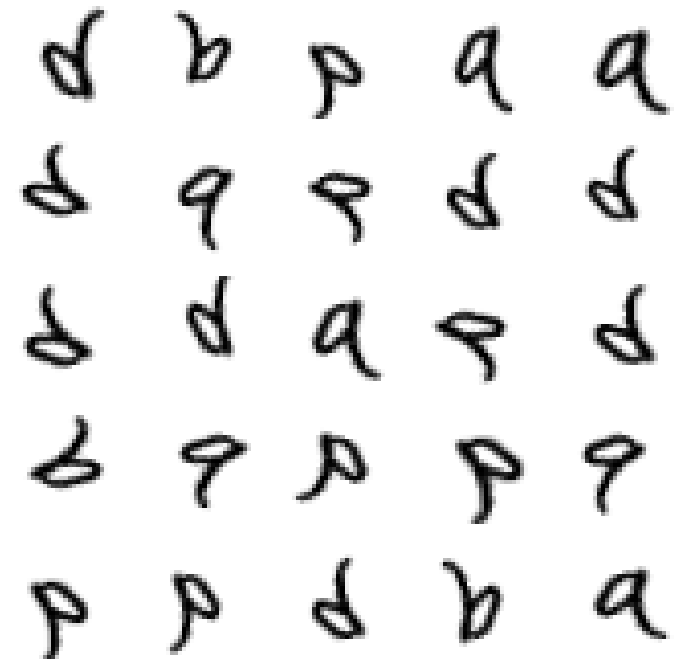

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:7], y_train[4:7], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape(img_rows,img_cols),cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

In [ ]:
# Our old fully connected (dense) network
#model = Sequential()
#model.add(Dense(512, activation='relu', input_shape=(784,)))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)         

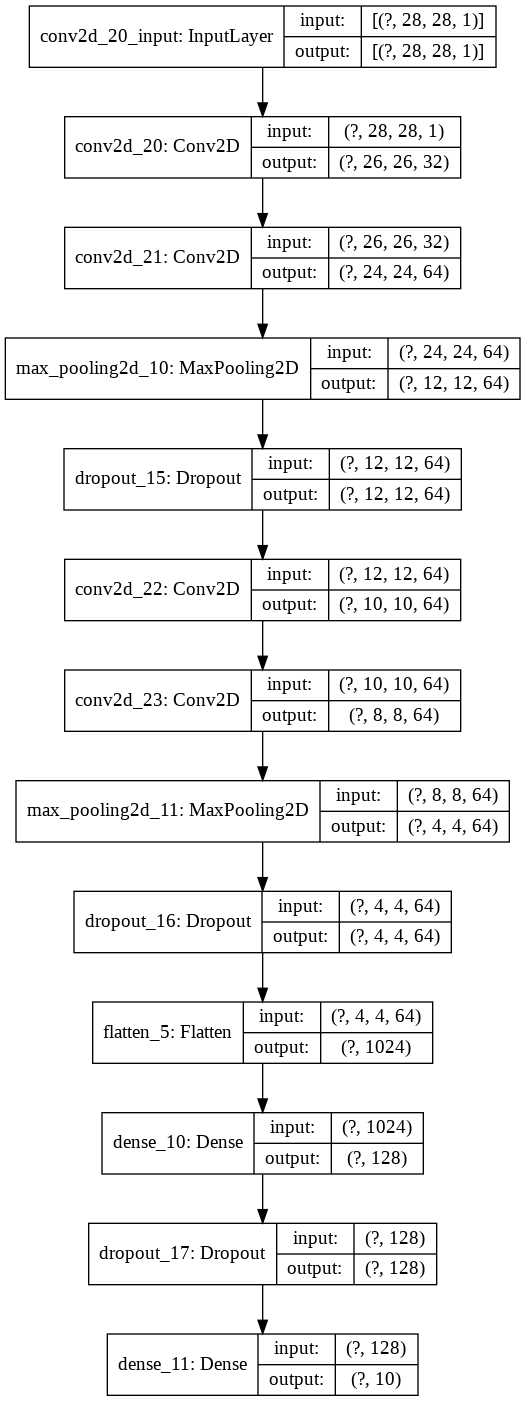

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_accuracy', patience =12, verbose=1)

history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks = [es])


Epoch 1/200
4/4 [==============================] - 1s 137ms/step - loss: 2.3028 - accuracy: 0.1020 - val_loss: 2.2891 - val_accuracy: 0.1881
Epoch 2/200
4/4 [==============================] - 0s 99ms/step - loss: 2.2801 - accuracy: 0.1640 - val_loss: 2.2628 - val_accuracy: 0.2335
Epoch 3/200
4/4 [==============================] - 0s 100ms/step - loss: 2.2551 - accuracy: 0.1980 - val_loss: 2.2074 - val_accuracy: 0.3023
Epoch 4/200
4/4 [==============================] - 0s 97ms/step - loss: 2.2218 - accuracy: 0.1980 - val_loss: 2.1099 - val_accuracy: 0.3263
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 2.1385 - accuracy: 0.2680 - val_loss: 1.9537 - val_accuracy: 0.3204
Epoch 6/200
4/4 [==============================] - 0s 93ms/step - loss: 2.1111 - accuracy: 0.2300 - val_loss: 1.8439 - val_accuracy: 0.3943
Epoch 7/200
4/4 [==============================] - 0s 96ms/step - loss: 2.0211 - accuracy: 0.2880 - val_loss: 1.7800 - val_accuracy: 0.3887
Epoch 8/200
4/4 [=

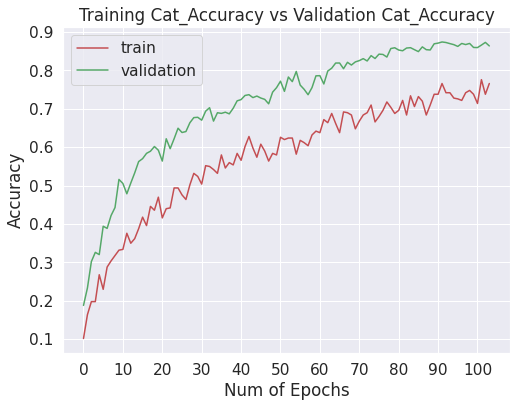

In [ ]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])




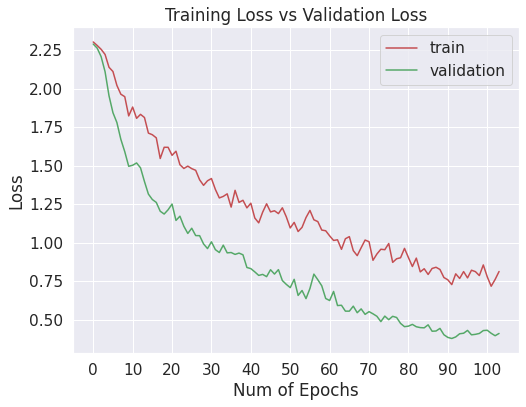

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.410916268825531
Test accuracy: 0.8639000058174133


In [ ]:

# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 92.60% , Test: 86.39% 


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



313/313 - 0s
[[ 966    0    2    0    0    0    7    1    0    4]
 [   0 1119    6    0    0    1    1    8    0    0]
 [   2    0  870    4    7   66   37   45    0    1]
 [   0    0  102  865    1   22    2   11    6    1]
 [   2    4    1    0  948    0   10    4    1   12]
 [   6    2  138   37    0  652   17   26    2   12]
 [  18    3    3    1    0    0  809   40    0   84]
 [   1   16   48    0   20    2   37  902    1    1]
 [  13    0   18    9    4    1   62    1  820   46]
 [  53    6    4    6   11    0  216   25    0  688]]


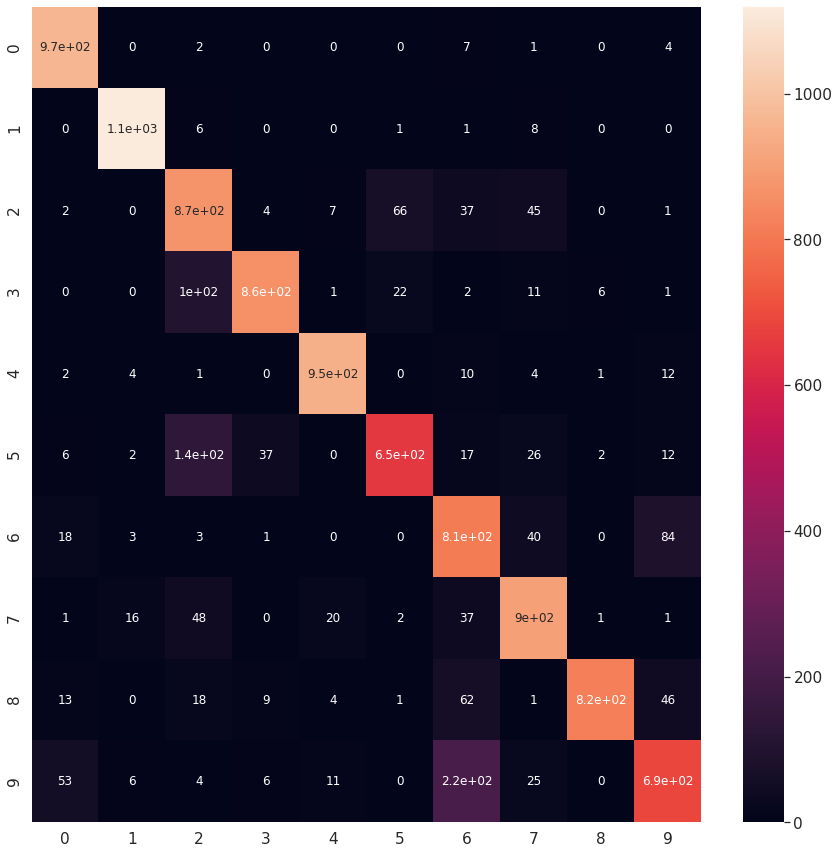

In [ ]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


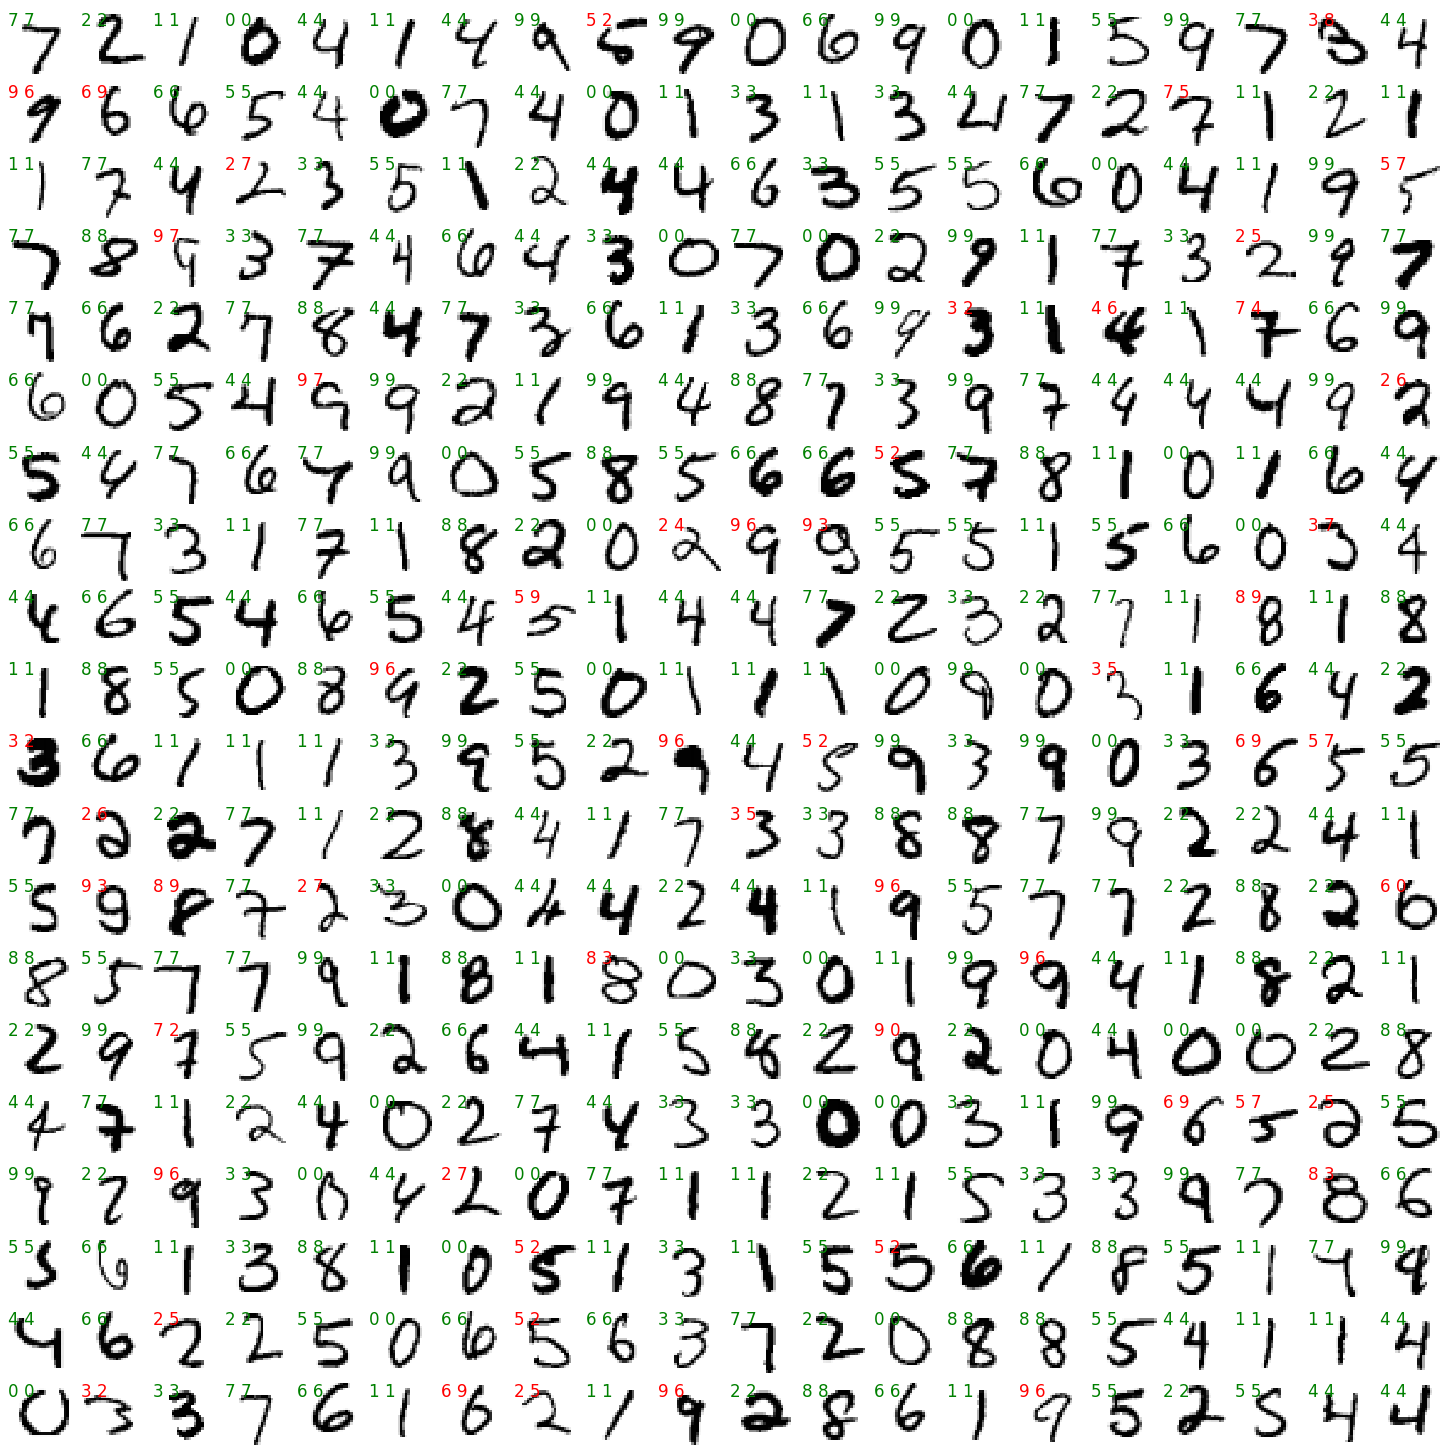

In [ ]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

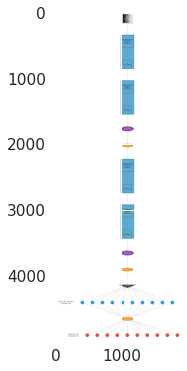

In [ ]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()
